<a href="https://colab.research.google.com/github/TheBlondMyth/AlgoTrading/blob/main/NB7.2_Optimal_market_making.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimal market making


---

This is a simple notebook demonstrating the numerical behaviours of the solution to the optimal market making problem.

# Recap of the model

Recall the model consists of the following components:

* Mid-price process of the stock is $S=(S_t)_{t\geq 0}$ with $dS_t=\sigma dB_t$ where $B$ is a Brownian motion.

* Depth levels of the limit buy and sell order are $\delta^b=(\delta^b_t)_{t\geq 0}$ and $\delta^a=(\delta^a_t)_{t\geq 0}$, such that at time $t$ the price level of the limit buy order is $S_t-\delta^b_t$ and that of the limit sell order is $S_t+\delta^a_t$.

* Cumulative shares purchased and sold respectively are denoted by $Y^b=(Y^b_t)_{t\geq 0}$ and $Y^a=(Y^a_t)_{t\geq 0}$, which are Cox processes with intensity functions $$\lambda^b_t=\lambda^b_0 e^{-\kappa \delta^b_t} \mathbb{I}(Q_{t-}<\overline{q}),\qquad \lambda^a_t=\lambda^a_0 e^{-\kappa \delta^a_t} \mathbb{I}(Q_{t-}>\underline{q}).$$ The indicator functions capture the constraint that the net inventory must satisfy $\underline{q}\leq Q_t\leq \overline{q}$.

* The inventory process $Q=(Q_t)_{t\geq 0}$ is given by $Q_t=Y^b_t-Y^a_t$.

* Cash process of the trader is $X=(X_t)_{t\geq 0}$ following $dX_t=(S_t+\delta_t)dY^a_t-(S_t-\delta^b_t)dY^b_t$.

The goal of the trader is to solve $$\sup_{\delta^b,\delta^a}\mathbb{E}\left[X_T+Q_T(S_T-\alpha Q_T)-\phi\int_0^T (Q_u)^2 du\right]$$ where $\alpha$ is the cost/penalty parameter of terminal liquidation and $\phi$ is the running inventory penalty.

Refer to the lecture notes for the expression of the optimal strategy (which is a bit too complicated to be included on this notebook).

# Numerical illustrations

Now we plot the optimal depths (bid and ask) under different time points and current inventory levels.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.linalg import expm

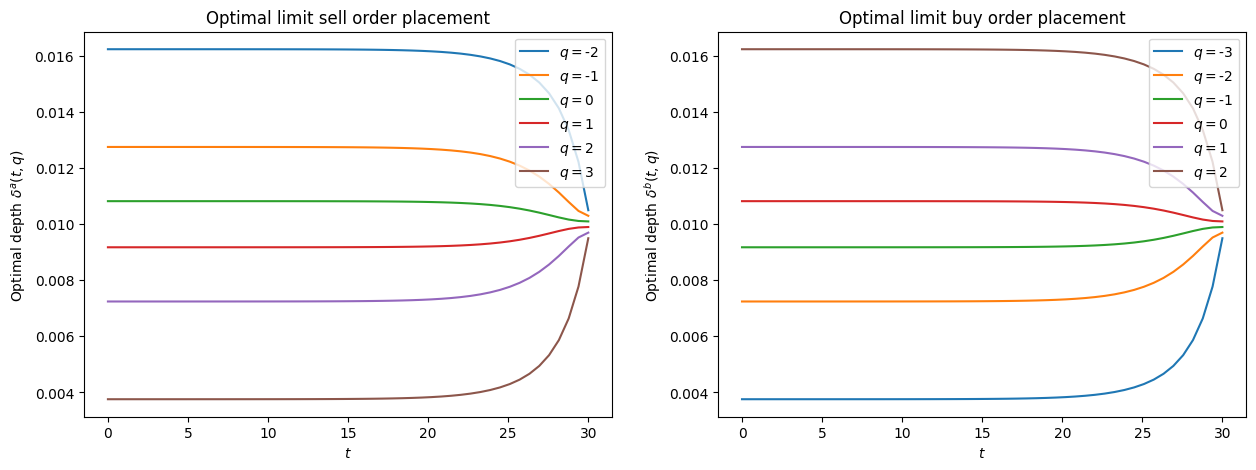

In [ ]:
T = 30
phi = 1e-5
lam_a, lam_b = 1, 1
kappa = 100
q_up, q_low = 3, -3
alpha = 0.0001

t = np.linspace(0, T)
q = np.arange(q_low, q_up + 1)
n = len(q)

# Create the "A matrix"
diag_mid = kappa * phi * q**2
diag_up = -lam_b * np.exp(-1) * np.ones(n-1)
diag_low = -lam_a * np.exp(-1) * np.ones(n-1)
A = diags([diag_low, diag_mid, diag_up], [-1, 0, 1]).toarray()

# Create the "M^a and M^b" matrices
M_a = diags([-1*np.ones(n-1), np.concatenate([[0],np.ones(n-1)])], [-1, 0]).toarray()
M_b = diags([-1*np.ones(n-1), np.concatenate([np.ones(n-1),[0]])], [1, 0]).toarray()

# terminal condition
z = np.exp(-kappa*alpha*q**2)

delta_a_all = np.zeros((len(t), n))
delta_b_all = np.zeros((len(t), n))

# compute the optimal depth
for j, tt in enumerate(t):
    w = np.matmul(expm(-A*(T-tt)), z)
    h = np.log(w) / kappa
    delta_a_all[j, : ] = 1/kappa + np.matmul(M_a,h)
    delta_b_all[j, : ] = 1/kappa + np.matmul(M_b,h)

# plot the results
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(15,5))
for i, q in enumerate(np.arange(q_low, q_up + 1)):

    if q > q_low:
        ax1.plot(t, delta_a_all[:, i], label = '$q=$' + str(q))

    if q < q_up:
        ax2.plot(t, delta_b_all[:, i], label = '$q=$' + str(q))


ax1.set_xlabel(r'$t$')
ax1.set_ylabel(r'Optimal depth $\delta^a(t,q)$ ')
ax1.set_title(r'Optimal limit sell order placement')
ax1.legend()

ax2.set_xlabel(r'$t$')
ax2.set_ylabel(r'Optimal depth $\delta^b(t,q)$ ')
ax2.set_title(r'Optimal limit buy order placement')
ax2.legend()